### Import Libraries


In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Load Data

In [297]:
# Load data
df = pd.read_csv('../dataset/data.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [298]:
# Variables table
df_variables = pd.read_csv('../dataset/variables.csv')
df_variables.head(len(df_variables))

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,NaN,NaN,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",NaN,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",NaN,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",NaN,no
4,default,Feature,Binary,NaN,has credit in default?,NaN,no
5,balance,Feature,Integer,NaN,average yearly balance,euros,no
6,housing,Feature,Binary,NaN,has housing loan?,NaN,no
7,loan,Feature,Binary,NaN,has personal loan?,NaN,no
8,contact,Feature,Categorical,NaN,contact communication type (categorical: 'cell...,NaN,yes
9,day_of_week,Feature,Date,NaN,last contact day of the week,NaN,no


In [299]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


#### Target Variable

In [300]:
# Target variable
df_target = pd.read_csv('../dataset/labels.csv')
df_target.head()

,y
0,no
1,no
2,no
3,no
4,no


In [301]:
# Value counts
df_target['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [302]:
# Normalised value counts
df_target['y'].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

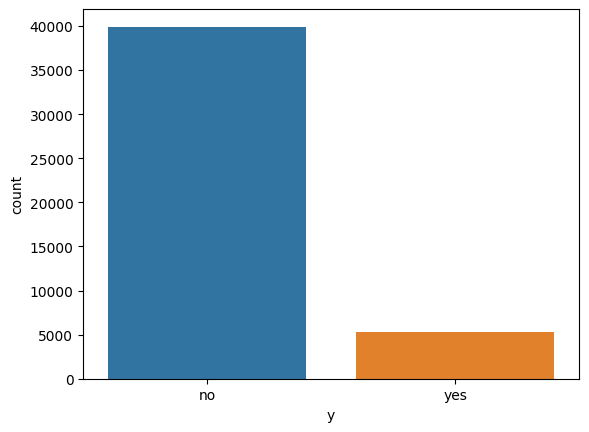

In [303]:
# Visualise the target variable
sns.countplot(x='y', data=df_target, hue='y')
plt.show()

### Exploratory Data Analysis

#### Missing Values

In [304]:
# Count missing values per column
df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

In [305]:
# Replace missing values

# Numerical columns have no missing values

# Categorical columns
df = df.fillna(value={'job' : 'missing'})
df = df.fillna(value={'education' : 'missing'})
df = df.fillna(value={'contact' : 'missing'})
df = df.fillna(value={'poutcome' : 'missing'})


In [306]:
# Recount missing values per column
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
dtype: int64

#### Unique Values

In [307]:
# Investigate unique values
df.nunique()

age              77
job              12
marital           3
education         4
default           2
balance        7168
housing           2
loan              2
contact           3
day_of_week      31
month            12
duration       1573
campaign         48
pdays           559
previous         41
poutcome          4
dtype: int64

#### Categorical Variables

In [308]:
# Add the 'y' column from df_target as a new column in df
df['y'] = df_target['y']
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,missing,5,may,261,1,-1,0,missing,no
1,44,technician,single,secondary,no,29,yes,no,missing,5,may,151,1,-1,0,missing,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,missing,5,may,76,1,-1,0,missing,no
3,47,blue-collar,married,missing,no,1506,yes,no,missing,5,may,92,1,-1,0,missing,no
4,33,missing,single,missing,no,1,no,no,missing,5,may,198,1,-1,0,missing,no


In [309]:
# Categorical Variables
def explore_categorical(col_name):   
    print("{0} Summary".format(col_name))
    print("\n")
    
    # Print the count of each category
    print("{0} Counts".format(col_name))
    print(df[col_name].value_counts())
    print("\n")

    # Print the ratio of each category
    print("{0} Ratio".format(col_name))
    print(df[col_name].value_counts(normalize=True))
    print("\n")
    
    # Print counts of y grouped by the categorical column
    print("{0} Default Counts".format(col_name))
    print(df.groupby(col_name)['y'].value_counts().unstack(level=-1))
    print("\n")

    # Print ratio of y grouped by the categorical column
    print("{0} Default Ratio".format(col_name))
    print(df.groupby(col_name)['y'].value_counts(normalize=True).unstack(level=-1))
    print("\n")

    # Plot ratio of y by the categorical column
    sns.catplot(data=df, kind='count', x=col_name, hue='y')
    plt.xticks(rotation=45) 
    plt.tight_layout()      
    plt.show()  

job Summary


job Counts
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
missing           288
Name: count, dtype: int64


job Ratio
job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
missing          0.006370
Name: proportion, dtype: float64


job Default Counts
y                no   yes
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
missing         254    34
retired        1748   516
self-employed  1392   187
services       3785   369
student      

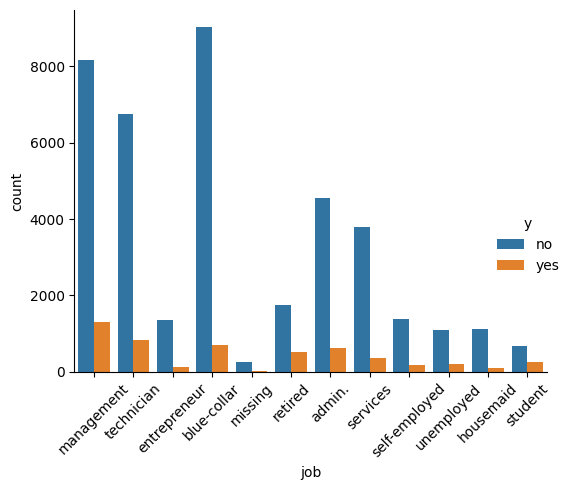

In [310]:
# Explore job column
explore_categorical('job')

#### Continuous Variables

In [311]:
# Continous Variables 
def explore_continuous(col_name):
    # Print statistical summary
    print("{0} Summary".format(col_name))
    print("\n")
    print(df[col_name].describe())
    print("\n")

    # Look at boxplot
    sns.boxplot(x=col_name, data=df)
    plt.show()

    # Look at the distribution
    sns.displot(df[col_name], kde=True)
    plt.show()

    # Grouping with the target variable 
    print("{0} Grouped Summary".format(col_name))
    print("\n")
    print(df.groupby('y')[col_name].describe())

    # Look at grouped boxplot 
    sns.boxplot(x=col_name, y='y', data=df, orient="h")
    plt.show()

balance Summary


count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64




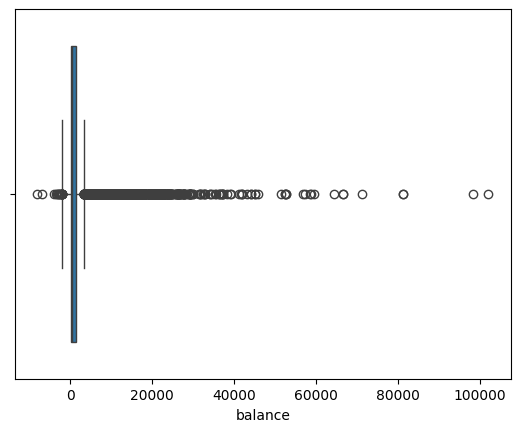

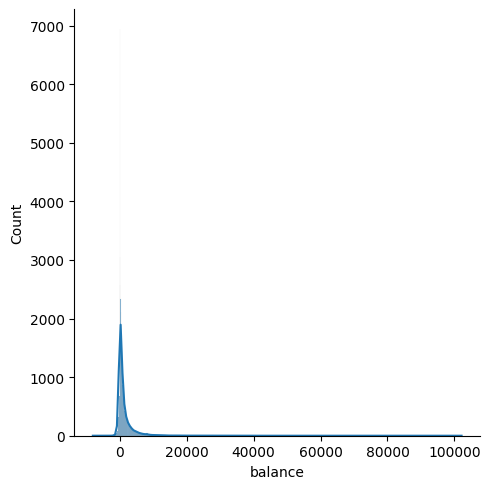

balance Grouped Summary


       count         mean          std     min    25%    50%     75%       max
y                                                                             
no   39922.0  1303.714969  2974.195473 -8019.0   58.0  417.0  1345.0  102127.0
yes   5289.0  1804.267915  3501.104777 -3058.0  210.0  733.0  2159.0   81204.0


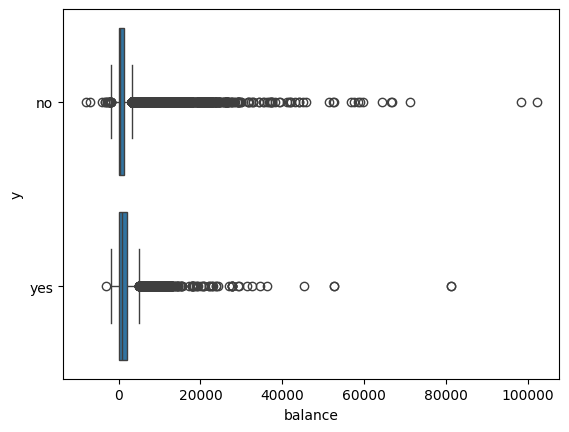

In [312]:
# Explore age column
explore_continuous('balance') 

housing Summary


housing Counts
housing
yes    25130
no     20081
Name: count, dtype: int64


housing Ratio
housing
yes    0.555838
no     0.444162
Name: proportion, dtype: float64


housing Default Counts
y           no   yes
housing             
no       16727  3354
yes      23195  1935


housing Default Ratio
y              no       yes
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000




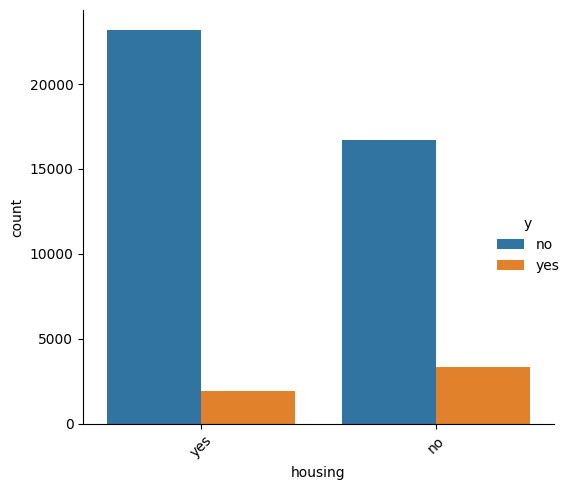

In [313]:
# Binary Variables
explore_categorical('housing')

### Feature Engineering

#### Binning

#### Normalisation

##### Numerical Columns

In [314]:
numerical_columns = df_variables[df_variables['type'] == 'Integer']['name'].tolist()
print(numerical_columns)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


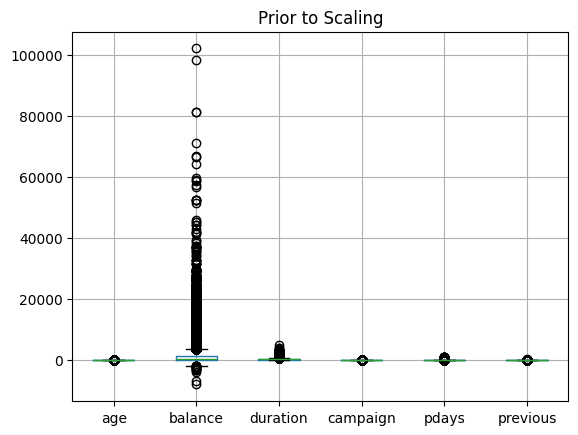

In [315]:
# Prior to scaling
df[numerical_columns].boxplot()
plt.title('Prior to Scaling')
plt.show()

In [316]:
# Min-max normalisation
mm_scalar = MinMaxScaler()
df[numerical_columns] = mm_scalar.fit_transform(df[numerical_columns])

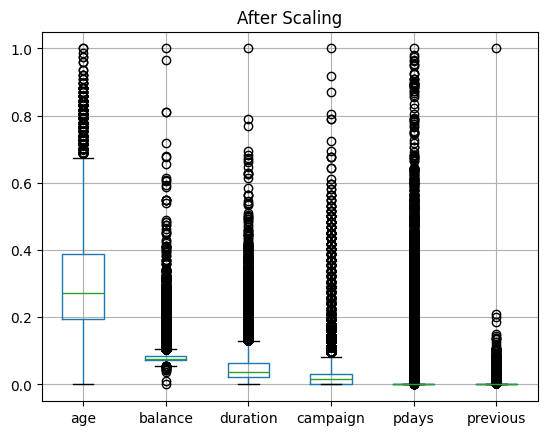

In [317]:
# After scaling
df[numerical_columns].boxplot()
plt.title('After Scaling')
plt.show()

##### Binary Columns

In [318]:
binary_columns = df_variables[df_variables['type'] == 'Binary']['name'].tolist()
print(binary_columns)

['default', 'housing', 'loan', 'y']


In [319]:
df[binary_columns] = df[binary_columns].apply(lambda col: col.map({'yes': 1, 'no': 0}))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,management,married,tertiary,0,0.092259,1,0,missing,5,may,0.053070,0.0,0.0,0.0,missing,0
1,0.337662,technician,single,secondary,0,0.073067,1,0,missing,5,may,0.030704,0.0,0.0,0.0,missing,0
2,0.194805,entrepreneur,married,secondary,0,0.072822,1,1,missing,5,may,0.015453,0.0,0.0,0.0,missing,0
3,0.376623,blue-collar,married,missing,0,0.086476,1,0,missing,5,may,0.018707,0.0,0.0,0.0,missing,0
4,0.194805,missing,single,missing,0,0.072812,0,0,missing,5,may,0.040260,0.0,0.0,0.0,missing,0


##### Categorical Columns

###### Ordinal Columns

In [320]:
ordinal_column = 'education'
categories = sorted(df[ordinal_column].unique())

In [321]:
# Ordinal-encoding
df[ordinal_column] = df[ordinal_column].apply(lambda x: (categories.index(x)) / (len(categories) - 1))

print(df[ordinal_column].value_counts())

education
0.666667    23202
1.000000    13301
0.333333     6851
0.000000     1857
Name: count, dtype: int64


###### Nominal Columns

In [322]:
nominal_column = df_variables[
    (df_variables['type'] == 'Categorical') & 
    (df_variables['name'] != 'education')
]['name'].tolist()
print(nominal_column)

['job', 'marital', 'contact', 'poutcome']


In [323]:
# One-hot encoding
df = pd.get_dummies(df, columns=nominal_column, drop_first=False)
new_cols = [col for col in df.columns if any(orig_col + '_' in col for orig_col in nominal_column)]
df[new_cols] = df[new_cols].astype(int)

df.head()

,age,education,default,balance,housing,loan,day_of_week,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,may,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,may,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,may,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,may,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,may,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


##### Date Columns

In [324]:
# explore_categorical('day')

# Rename 'day_of_week' to 'day' 
df.rename(columns={'day_of_week': 'day'}, inplace=True)
df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,may,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,may,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,may,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,may,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,may,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


In [325]:
# explore_categorical('month')

# Convert month names to month numbers
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_map)

df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,5,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,5,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,5,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,5,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,5,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


In [326]:

# Cyclical encoding for day of the month (assuming max 31 days)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Cyclical encoding for month (12 months in a year)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.head()


,age,education,default,balance,housing,loan,day,month,duration,campaign,...,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success,day_sin,day_cos,month_sin,month_cos
0,0.519481,1.000000,0,0.092259,1,0,5,5,0.053070,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
1,0.337662,0.666667,0,0.073067,1,0,5,5,0.030704,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
2,0.194805,0.666667,0,0.072822,1,1,5,5,0.015453,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
3,0.376623,0.000000,0,0.086476,1,0,5,5,0.018707,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
4,0.194805,0.000000,0,0.072812,0,0,5,5,0.040260,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025


In [327]:
# Drop the original 'month' and 'day_of_week' columns
df.drop(columns=['month', 'day'], inplace=True)

df.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success,day_sin,day_cos,month_sin,month_cos
0,0.519481,1.000000,0,0.092259,1,0,0.053070,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
1,0.337662,0.666667,0,0.073067,1,0,0.030704,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
2,0.194805,0.666667,0,0.072822,1,1,0.015453,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
3,0.376623,0.000000,0,0.086476,1,0,0.018707,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
4,0.194805,0.000000,0,0.072812,0,0,0.040260,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025


### Train/Validation/Test Split

### ANN

### Model Evaluation

In [328]:
# Confusion Matrix
# Precision
# Recall
# F1 Score

In [329]:
# Decaying learning rate and non decaying learning rate